In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
#@title imports

import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py

from sklearn.preprocessing import StandardScaler

import seaborn as sns
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [ ]:
dataset = pd.read_csv('Mall_Customers.csv')
dataset.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'}, inplace=True)
dataset.drop('CustomerID',axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dataset['Gender'].values)
dataset['Gender'] = integer_encoded
dataset.head(3)

,Gender,Age,Income,Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6


In [ ]:
#@title tests for the code
class SanityCheck:
    def test_dirichlet_sampling():
        c = FCM(0.3,
                3,
                100,
                2,
                metric='cosine')
        c.n_samples=60
        membership_degree = c.get_random_dirichlet_membership(None)
        sampling_sanity_check = membership_degree.sum(axis=1)
        np.testing.assert_array_almost_equal(sampling_sanity_check,
                                             np.ones_like(sampling_sanity_check))

    def test_distance_metrics_euclidean():
        c = FCM(0.3,
                1,
                1,
                2,
                metric='euclidean')
        x = np.array([[0,0]])
        y = np.array([[1,1]])
        dist = c.metric(x,y)
        dist_expected = np.array(np.sqrt(2))
        np.testing.assert_array_almost_equal(dist,
                                             dist_expected)

    def test_distance_metrics_euclidean_2vs1datapoints():
        c = FCM(0.3,
                1,
                1,
                2,
                metric='euclidean')
        x = np.array([[0,0],
                      [1,1]])
        y = np.array([[1,1]])
        dist1 = c.metric(x,y)
        dist2 = c.metric(y,x)
        dist_expected = np.array([np.sqrt(2),
                                  0.0])
        np.testing.assert_array_almost_equal(dist1,
                                             dist_expected)
        np.testing.assert_array_almost_equal(dist2,
                                             dist_expected)

    def __init__(self):
        for func_name in dir(SanityCheck):
            if func_name.startswith("test_"):
                getattr(SanityCheck,func_name)()
        print("all tests OK.")

SanityCheck()

all tests OK.


In [ ]:
#@title IT2FCM
class FCM:
    def __init__(self,
                 min_improvement,
                 n_clusters,
                 max_iterations,
                 fuzzification_degree,
                 dirichlet_concentration_params=None,
                 metric='euclidean',
                 verbose=False):
        self.objective = np.inf
        self.objective_history = []
        self.max_iterations = max_iterations
        self.min_improvement = min_improvement
        self.n_clusters = n_clusters
        self.fuzzification_degree = fuzzification_degree
        self.dirichlet_concentration_params = dirichlet_concentration_params
        self.metric = self.__get_metric(metric)
        self.verbose = verbose

    def get_random_dirichlet_membership(self,dirichlet_concentration_params):

        if dirichlet_concentration_params is None:
            dirichlet_concentration_params = np.array([2.0]*self.n_clusters)

        assert dirichlet_concentration_params.shape[0] == self.n_clusters, \
            f"dirichlet_concentration_params {dirichlet_concentration_params} does not match the number of clusters {n_clusters}"

        return np.random.dirichlet(dirichlet_concentration_params,size=self.n_samples)

    def set_membership_degree(self,membership_degree):
        self.membership_degree = membership_degree

    def fit(self,X,init_membership_degree=None):
        self.X = X
        self.n_samples, self.n_features = self.X.shape
        self.distance_matrix = np.zeros(shape=(self.n_samples,self.n_clusters))
        if init_membership_degree is None:
            init_membership_degree = self.get_random_dirichlet_membership(self.dirichlet_concentration_params)
        self.set_membership_degree(init_membership_degree)
        self.normalize_membership_degree()

        iteration = 0
        while True:
            self.update_centers()
            self.update_distances()
            self.update_membership_degree()
            self.update_objective()
            if self.stopping_criterion(iteration):
                break
            iteration += 1
            if self.verbose:
                print(iteration,self.objective_history[-1])

    def update_centers(self):
        self.fuzzy_membership_degree = self.membership_degree ** self.fuzzification_degree
        self.centers = (self.fuzzy_membership_degree.T @ self.X)/np.expand_dims(self.fuzzy_membership_degree.sum(axis=0),1)

    def update_objective(self):
        self.objective = (self.fuzzy_membership_degree * self.distance_matrix_squared).sum()
        self.objective_history.append(self.objective)

    def stopping_criterion(self,iteration):
        if iteration > self.max_iterations:
            return True

        if iteration > 2:
            self.improvement = np.abs(self.objective_history[-2] - self.objective_history[-1])
            return self.improvement < self.min_improvement

        return False

    def update_distances(self):
        for center_idx in range(self.n_clusters):
            self.distance_matrix[:,center_idx] = self.metric(np.expand_dims(self.centers[center_idx],0),self.X)

    def update_membership_degree(self):
        self.distance_matrix_squared = self.distance_matrix ** 2
        for center_idx in range(self.n_clusters):
            for sample_idx in range(self.n_samples):
                temp = self.distance_matrix_squared[sample_idx,center_idx]/self.distance_matrix_squared[sample_idx,:]
                self.membership_degree[sample_idx,center_idx] = 1/((temp.sum())**(2/(self.fuzzification_degree-1)))
        self.normalize_membership_degree()

    def normalize_membership_degree(self):
        self.membership_degree = self.membership_degree/self.membership_degree.sum(axis=1,keepdims=True)

    def __get_metric(self,name):
        metrics = {'euclidean' : self.__euclid_metric,
                   'cosine': self.__cosine_metric}
        return metrics[name]

    def __euclid_metric(self,x,y):
        return np.linalg.norm(x-y,axis=1)

    def __cosine_metric(self,x,y):
        return 1 - np.dot(x,y.T)/(np.linalg.norm(x)*np.linalg.norm(y))

class IT2FCM(FCM):
    def __init__(self,
                 min_improvement,
                 n_clusters,
                 max_iterations,
                 fuzzification_degree,
                 dirichlet_concentration_params=None,
                 metric='euclidean',
                 tuning_params=None,
                 verbose=False):
        super().__init__(min_improvement,
                         n_clusters,
                         max_iterations,
                         fuzzification_degree,
                         dirichlet_concentration_params=None,
                         metric=metric,
                         verbose=verbose)
        if tuning_params is None:
            self.tuning_params = 2.

    def update_type2_scores(self):
        self.type2_scores = self.membership_degree - (1-self.membership_degree)/2

    def update_uncertainty(self):
        self.uncertainty = 1-self.membership_degree-(1-self.membership_degree**self.tuning_params)**(1/self.tuning_params)

    def update_t2i_membership(self):
        self.t2i_membership = self.type2_scores+self.uncertainty

    def update_ifuzzy_membership(self):
        self.ifuzzy_membership_degree = self.membership_degree + self.uncertainty

    def update_ifuzzy_uncertainty(self):
        self.ifuzzy_uncertainty = self.uncertainty.mean(axis=0,
                                                        keepdims=True)

    def update_objective(self):
        self.update_ifuzzy_uncertainty()
        self.objective = (self.ifuzzy_membership_degree * self.distance_matrix_squared).sum() + (self.ifuzzy_uncertainty*np.exp(1-self.ifuzzy_uncertainty)).sum()
        self.objective_history.append(self.objective)

    def update_centers2(self):
        self.type2_scores = self.membership_degree - (1-self.membership_degree)/2
        self.uncertainty = 1-self.membership_degree-(1-self.membership_degree**self.tuning_params)**(1/self.tuning_params)
        self.t2i_membership = self.type2_scores+self.uncertainty
        self.t2i_membership =self.t2i_membership ** self.fuzzification_degree
        self.centers = (self.t2i_membership.T @ self.X)/np.expand_dims(self.t2i_membership.sum(axis=0),1)
    def vpc(self):
        newu=(self.membership_degree)**2
        self._vpc = newu.sum()/(self.n_samples)
        return self._vpc
    def fit(self,X,init_membership_degree=None):
        self.X = X
        self.n_samples, self.n_features = self.X.shape
        self.distance_matrix = np.zeros(shape=(self.n_samples,self.n_clusters))
        if init_membership_degree is None:
            init_membership_degree = self.get_random_dirichlet_membership(self.dirichlet_concentration_params)
        self.set_membership_degree(init_membership_degree)
        self.normalize_membership_degree()
        self.update_centers()

        iteration = 0
        while True:
            self.update_distances()
            self.update_membership_degree()
            self.update_uncertainty()
            self.update_type2_scores()
            self.update_centers2()
            self.update_ifuzzy_membership()
            self.update_objective()
            self.update_membership_degree()
            if self.stopping_criterion(iteration):
                print(self.MCD(),self.xi_beni(),self.lables())
                break
            iteration += 1
            if self.verbose:
                print(self.xi_beni(),self.vpc())
    def xi_beni(self):
         b=[]
         for i in (self.centers):
            for j in (self.centers):
                  b.append((np.linalg.norm(i-j))**2)
            if 0 in b:
                b.remove(0)
         b.sort()
         c=b[0]
         self.a=(self.n_samples)*c
         return self.a
    def MCD(self):
        M=[]
        for i in (self.centers):
          for j in (self.centers):
            M.append((np.linalg.norm(i-j))**2)
            if 0 in M:
                M.remove(0)
        M.sort()
        self.F=M[0]
        return self.F
    def lables(self):
        self.predict= np.argmax(self.membership_degree, axis=1)
        return self.predict

298.898667874583 59779.7335749166 [0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
217.13155603126674 43426.31120625335 [0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0 0 2 0 2 0 2 0 2 0
 2 0 2 0 2 0 2 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0
 0 2 0 0 2 0 0 2 0 0 2 0 0 2 2 0 0 1 0 0 1 2 0 2 0 2 1 1 1 2 1 1 1 1 0 1 1
 2 1 1 2 2 1 2 1 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 1 1 2 1 1 1 2 1 1 1 1 1 1]
130.4271924438893 26085.43848877786 [3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3

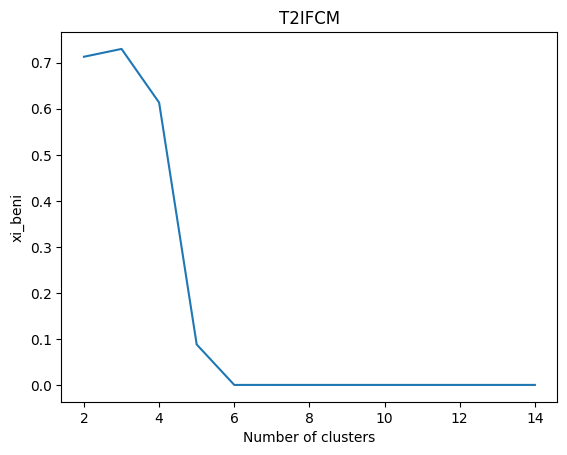

In [ ]:
#@title Determining optimal number of clusters using xi and beni index
cmin=2
n_samples=200
cmax=np.sqrt(n_samples)
cmax=int(cmax)
cmax+=1
hub=[]
clusters = range(cmin,cmax)
epsilon = 0.5
x=dataset
for i in clusters:
    n_centers=i
    clustering_instance = IT2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
    np_x = x.to_numpy()
    clustering_instance.fit(np_x)
    hub.append((clustering_instance.a)/clustering_instance.objective_history[-1])
print(hub)
plt.title("T2IFCM")
plt.xlabel('Number of clusters')
plt.ylabel('xi_beni')
plt.plot(clusters,hub)

121.15224881351652 24230.449762703305 [1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
281.35189835331465 56270.37967066293 [0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 2 1 1 1 2 1 2 1 2 2 1 2 2 2 2 1 1 1 1 1
 2 1 2 2 2 1 2 1 2 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
129.10300375797988 25820.600751595975 [3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 

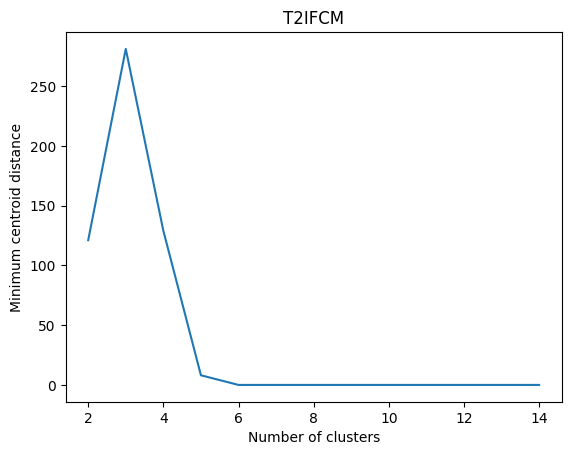

In [ ]:
#@ title Determining optimal number of clusters using Ⅿiniⅿuⅿ ⅽentroiⅾ ⅾistanⅽe index
cmin=2
n_samples=200
cmax=np.sqrt(n_samples)
cmax=int(cmax)
cmax+=1
hub=[]
clusters = range(cmin,cmax)
epsilon = 0.5
x=dataset
for i in clusters:
    n_centers=i
    clustering_instance = IT2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
    np_x = x.to_numpy()
    clustering_instance.fit(np_x)
    hub.append(clustering_instance.F)
plt.title("T2IFCM")
plt.xlabel('Number of clusters')
plt.ylabel('Ⅿiniⅿuⅿ ⅽentroiⅾ ⅾistanⅽe')
plt.plot(clusters,hub)

In [ ]:
#@title visualizations
n_centers = 2
epsilon = 0.5
x=dataset
clustering_instance = IT2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
np_x = x.to_numpy()
clustering_instance.fit(np_x)
x['Labels'] = clustering_instance.predict

707.6005569131862 141520.11138263723 [0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0
 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


<Figure size 1200x800 with 0 Axes>

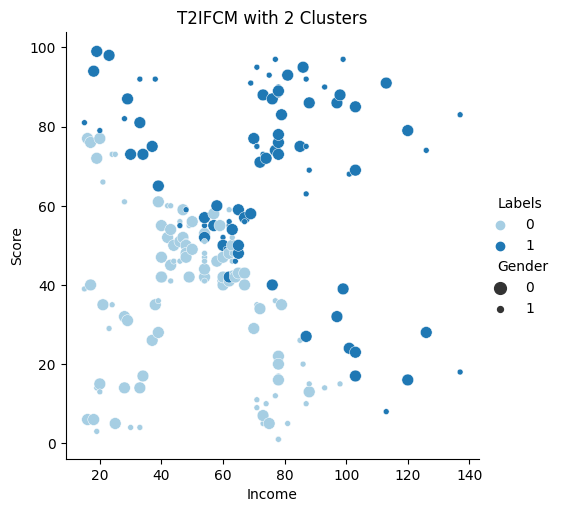

In [ ]:
x['Labels'] = clustering_instance.predict
clustering_centers = clustering_instance.centers
plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")

plt.title('T2IFCM with 2 Clusters')
plt.show()

In [ ]:
n_centers = 3
epsilon = 0.5
x=dataset
clustering_instance = IT2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
np_x = x.to_numpy()
clustering_instance.fit(np_x)
x['Labels'] = clustering_instance.predict

281.87707394928924 56375.414789857845 [1 1 2 1 1 1 2 1 2 1 2 1 2 1 2 1 1 1 2 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1 2 2 1
 2 1 1 1 1 2 2 1 2 2 1 2 1 1 1 2 2 0 2 2 2 0 2 0 2 0 0 2 0 0 0 0 2 2 2 2 2
 0 2 0 0 0 2 0 2 0 0 2 0 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0 0 2 0 2 0
 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0]


<Figure size 1200x800 with 0 Axes>

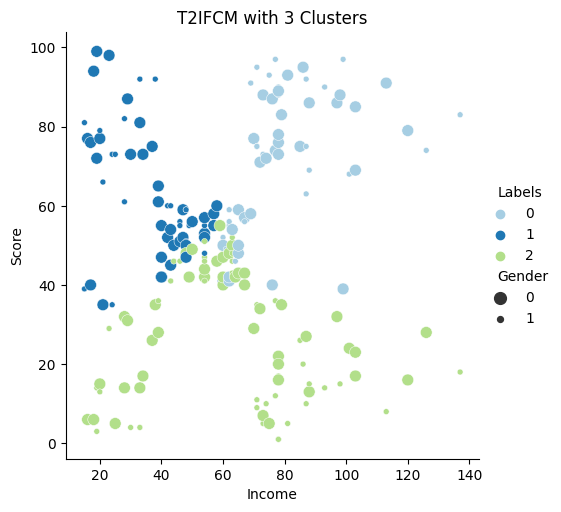

In [ ]:
x['Labels'] = clustering_instance.predict
clustering_centers = clustering_instance.centers
plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")

plt.title('T2IFCM with 3 Clusters')
plt.show()

In [ ]:
#@title Internal evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


print("Silhouette score: {}".format(silhouette_score(dataset.drop(['Labels'],axis=1), clustering_instance.predict)))
print("Davies Bouldin score: {}".format(davies_bouldin_score(dataset.drop(['Labels'], axis=1),  clustering_instance.predict)))
print("Calinski Harabasz score: {}".format(calinski_harabasz_score(dataset.drop(['Labels'], axis=1), clustering_instance.predict)))

Silhouette score: 0.26249883569445365
Davies Bouldin score: 1.154585055092241
Calinski Harabasz score: 84.41160557888497


In [ ]:
#@title External evaluation
from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=5).fit(x)
x['La'] = km5.labels_
x['Labels'] = clustering_instance.predict

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import rand_score
from sklearn.metrics import v_measure_score
print("Rand score: {}".format(rand_score(km5.labels_, clustering_instance.predict)))
print("fowlkes mallows score: {}".format(fowlkes_mallows_score(km5.labels_, clustering_instance.predict)))
print("v measure score: {}".format(v_measure_score(km5.labels_, clustering_instance.predict)))

Rand score: 0.6928643216080402
fowlkes mallows score: 0.48578374211762265
v measure score: 0.45296007085243783
